In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    continue
print("DONE")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DONE


In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

DATASET_PATH = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
OUTPUT_PATH = '/kaggle/working/melspec_data'  # updated folder name

os.makedirs(OUTPUT_PATH, exist_ok=True)

for genre in GENRES:
    genre_path = os.path.join(DATASET_PATH, genre)
    output_genre_path = os.path.join(OUTPUT_PATH, genre)
    os.makedirs(output_genre_path, exist_ok=True)

    for filename in os.listdir(genre_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(genre_path, filename)
            try:
                y, sr = librosa.load(file_path, duration=30)
                # Compute Mel-Spectrogram
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                # Plot and save image
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
                plt.axis('off')
                plt.tight_layout()
                save_path = os.path.join(output_genre_path, filename.replace('.wav', '.png'))
                plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
                plt.close()
            except Exception as e:
                print(f"Skipping {file_path}: {e}")

print("DONE")

/tmp/ipykernel_36/3276173408.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 
DONE


In [4]:
from torchvision import transforms

vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # optional: normalize to [-1, 1]
])

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

dataset = ImageFolder('melspec_data', transform=vit_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# --- Model, Optimizer, Loss ---
vit_model_mel = vit_b_16(weights='IMAGENET1K_V1') # Use updated weights parameter
vit_model_mel.heads[0] = nn.Linear(vit_model_mel.heads[0].in_features, len(GENRES))
vit_model_mel = vit_model_mel.to(device)

optimizer = torch.optim.Adam(vit_model_mel.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

# --- Training and Validation Loop ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
n_epochs = 50

# --- New: Early Stopping Initialization ---
patience = 5  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf')
best_model_state = None
# ------------------------------------------

for epoch in range(n_epochs):
    # --- Training Phase ---
    vit_model_mel.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = vit_model_mel(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * xb.size(0)
        correct_train += (pred.argmax(1) == yb).sum().item()
        total_train += yb.size(0)

    avg_train_loss = total_train_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # --- Validation Phase ---
    vit_model_mel.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            pred_val = vit_model_mel(xb_val)
            loss_val = loss_fn(pred_val, yb_val)
            
            total_val_loss += loss_val.item() * xb_val.size(0)
            correct_val += (pred_val.argmax(1) == yb_val).sum().item()
            total_val += yb_val.size(0)

    avg_val_loss = total_val_loss / total_val
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# --- New: Early Stopping Check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model state
        best_model_state = vit_model_mel.state_dict()
        patience_counter = 0
        print("Validation loss improved. Saving model.")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    # ---------------------------------

# --- New: Load the best model weights after training ---
if best_model_state:
    print("Loading best model weights.")
    vit_model_mel.load_state_dict(best_model_state)

print("Training finished.")

Epoch 1/50, Train Loss: 1.9395, Train Acc: 0.3079, Val Loss: 1.4492, Val Acc: 0.4850
Validation loss improved. Saving model.
Epoch 2/50, Train Loss: 1.1928, Train Acc: 0.5757, Val Loss: 0.9904, Val Acc: 0.6700
Validation loss improved. Saving model.
Epoch 3/50, Train Loss: 0.7413, Train Acc: 0.7459, Val Loss: 1.0569, Val Acc: 0.6350
Validation loss did not improve. Patience: 1/5
Epoch 4/50, Train Loss: 0.5432, Train Acc: 0.8098, Val Loss: 0.7714, Val Acc: 0.7250
Validation loss improved. Saving model.
Epoch 5/50, Train Loss: 0.2435, Train Acc: 0.9287, Val Loss: 0.6835, Val Acc: 0.7900
Validation loss improved. Saving model.
Epoch 6/50, Train Loss: 0.0930, Train Acc: 0.9762, Val Loss: 0.6343, Val Acc: 0.8150
Validation loss improved. Saving model.
Epoch 7/50, Train Loss: 0.0586, Train Acc: 0.9887, Val Loss: 1.0214, Val Acc: 0.7150
Validation loss did not improve. Patience: 1/5
Epoch 8/50, Train Loss: 0.0293, Train Acc: 0.9950, Val Loss: 0.7113, Val Acc: 0.8000
Validation loss did not im

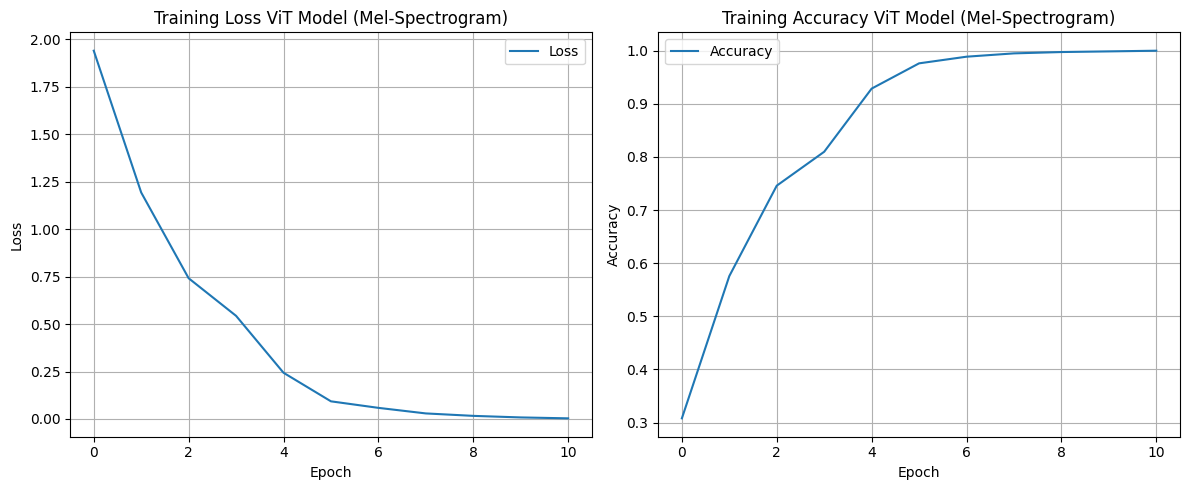

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title('Training Loss ViT Model (Mel-Spectrogram)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy')
plt.title('Training Accuracy ViT Model (Mel-Spectrogram)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

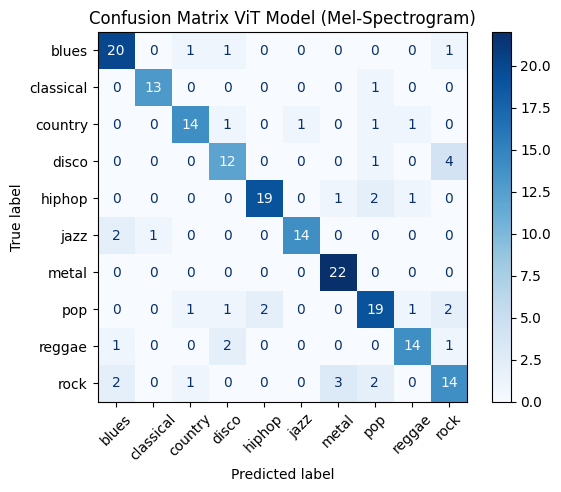

ViT(Mel-Spectrogram) Classification Report:


,precision,recall,f1-score,support
blues,0.800000,0.869565,0.833333,23.000
classical,0.928571,0.928571,0.928571,14.000
country,0.823529,0.777778,0.800000,18.000
disco,0.705882,0.705882,0.705882,17.000
hiphop,0.904762,0.826087,0.863636,23.000
jazz,0.933333,0.823529,0.875000,17.000
metal,0.846154,1.000000,0.916667,22.000
pop,0.730769,0.730769,0.730769,26.000
reggae,0.823529,0.777778,0.800000,18.000
rock,0.636364,0.636364,0.636364,22.000


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

vit_model_mel.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        outputs = vit_model_mel(xb)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GENRES)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title('Confusion Matrix ViT Model (Mel-Spectrogram)')
plt.show()

# Classification Report
from pandas import DataFrame
print("ViT(Mel-Spectrogram) Classification Report:")
report = classification_report(y_true, y_pred, target_names=GENRES, output_dict=True, zero_division=0)
DataFrame(report).transpose()


In [9]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

DATASET_PATH = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
OUTPUT_PATH = '/kaggle/working/mfcc_data'

os.makedirs(OUTPUT_PATH, exist_ok=True)

for genre in GENRES:
    genre_path = os.path.join(DATASET_PATH, genre)
    output_genre_path = os.path.join(OUTPUT_PATH, genre)
    os.makedirs(output_genre_path, exist_ok=True)

    for filename in os.listdir(genre_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(genre_path, filename)
            try:
                y, sr = librosa.load(file_path, duration=30)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(mfcc, x_axis='time')
                plt.axis('off')
                plt.tight_layout()
                save_path = os.path.join(output_genre_path, filename.replace('.wav', '.png'))
                plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
                plt.close()
            except Exception as e:
                print(f"Skipping {file_path}: {e}")

print("DONE")

/tmp/ipykernel_36/2623598827.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 
DONE


In [10]:
from torchvision import transforms

vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # optional: normalize to [-1, 1]
])

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

dataset = ImageFolder('mfcc_data', transform=vit_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# --- Model, Optimizer, Loss ---
vit_model_mfcc = vit_b_16(weights='IMAGENET1K_V1') # Use updated weights parameter
vit_model_mfcc.heads[0] = nn.Linear(vit_model_mfcc.heads[0].in_features, len(GENRES))
vit_model_mfcc = vit_model_mfcc.to(device)

optimizer = torch.optim.Adam(vit_model_mfcc.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

# --- Training and Validation Loop ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
n_epochs = 50

# --- New: Early Stopping Initialization ---
patience = 5  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf')
best_model_state = None
# ------------------------------------------

for epoch in range(n_epochs):
    # --- Training Phase ---
    vit_model_mfcc.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = vit_model_mfcc(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * xb.size(0)
        correct_train += (pred.argmax(1) == yb).sum().item()
        total_train += yb.size(0)

    avg_train_loss = total_train_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # --- Validation Phase ---
    vit_model_mfcc.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            pred_val = vit_model_mfcc(xb_val)
            loss_val = loss_fn(pred_val, yb_val)
            
            total_val_loss += loss_val.item() * xb_val.size(0)
            correct_val += (pred_val.argmax(1) == yb_val).sum().item()
            total_val += yb_val.size(0)

    avg_val_loss = total_val_loss / total_val
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# --- New: Early Stopping Check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model state
        best_model_state = vit_model_mfcc.state_dict()
        patience_counter = 0
        print("Validation loss improved. Saving model.")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    # ---------------------------------

# --- New: Load the best model weights after training ---
if best_model_state:
    print("Loading best model weights.")
    vit_model_mfcc.load_state_dict(best_model_state)

print("Training finished.")

Epoch 1/50, Train Loss: 1.9860, Train Acc: 0.2741, Val Loss: 1.3558, Val Acc: 0.4700
Validation loss improved. Saving model.
Epoch 2/50, Train Loss: 1.3594, Train Acc: 0.5106, Val Loss: 1.1158, Val Acc: 0.6000
Validation loss improved. Saving model.
Epoch 3/50, Train Loss: 1.1350, Train Acc: 0.5982, Val Loss: 1.0428, Val Acc: 0.6300
Validation loss improved. Saving model.
Epoch 4/50, Train Loss: 0.8702, Train Acc: 0.6984, Val Loss: 0.9855, Val Acc: 0.6600
Validation loss improved. Saving model.
Epoch 5/50, Train Loss: 0.6931, Train Acc: 0.7685, Val Loss: 0.9434, Val Acc: 0.7350
Validation loss improved. Saving model.
Epoch 6/50, Train Loss: 0.5125, Train Acc: 0.8298, Val Loss: 0.8823, Val Acc: 0.7250
Validation loss improved. Saving model.
Epoch 7/50, Train Loss: 0.2452, Train Acc: 0.9349, Val Loss: 0.8509, Val Acc: 0.7350
Validation loss improved. Saving model.
Epoch 8/50, Train Loss: 0.1573, Train Acc: 0.9562, Val Loss: 1.1142, Val Acc: 0.6900
Validation loss did not improve. Patienc

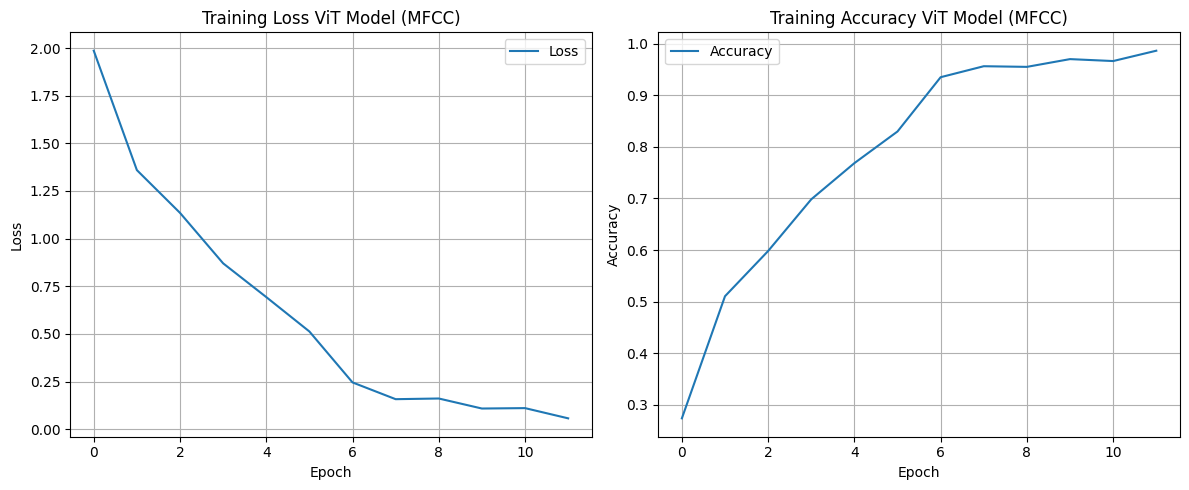

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title('Training Loss ViT Model (MFCC)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy')
plt.title('Training Accuracy ViT Model (MFCC)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

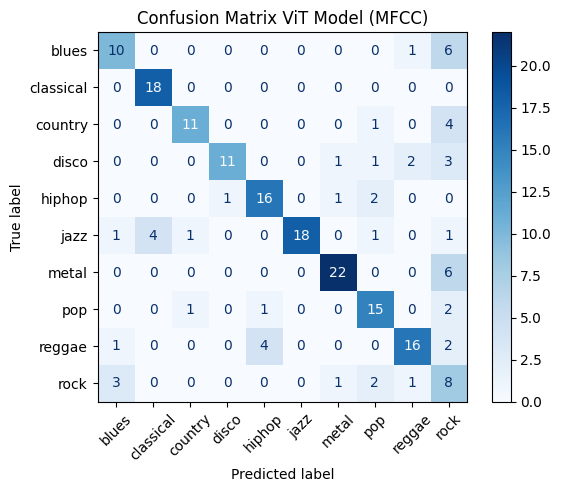

ViT(MFCC) Classification Report:


,precision,recall,f1-score,support
blues,0.666667,0.588235,0.625000,17.000
classical,0.818182,1.000000,0.900000,18.000
country,0.846154,0.687500,0.758621,16.000
disco,0.916667,0.611111,0.733333,18.000
hiphop,0.761905,0.800000,0.780488,20.000
jazz,1.000000,0.692308,0.818182,26.000
metal,0.880000,0.785714,0.830189,28.000
pop,0.681818,0.789474,0.731707,19.000
reggae,0.800000,0.695652,0.744186,23.000
rock,0.250000,0.533333,0.340426,15.000


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

vit_model_mfcc.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        outputs = vit_model_mfcc(xb)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GENRES)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title('Confusion Matrix ViT Model (MFCC)')
plt.show()

# Classification Report
from pandas import DataFrame
print("ViT(MFCC) Classification Report:")
report = classification_report(y_true, y_pred, target_names=GENRES, output_dict=True, zero_division=0)
DataFrame(report).transpose()
